In [40]:
# Import libraries for:

# Web scraping
import requests 
from bs4 import BeautifulSoup

# Data analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geopandas as gpd

# Import
from myfuncs import *


# Set random seed
np.random.seed(42)

# Unsupervised Learning
**Objectives:**
- Segment air travelers into distinct groups based on their states of origin, with the expectation that each group may exhibit unique air travel behaviors.
- Reduce the dimensionality of state-level data to eliminate feature correlations and redundancies.
- Perform clustering on the transformed features to identify meaningful traveler segments.

## Data Extraction & Preprocessing

In [6]:
# Extract data from US Census Bureau

# Define input variables for the extraction
apikey_USCB = 'b83c9e8cbf71b387db3681c39e0d7ef719f6344f'
variables_USCB = ['B19013_001E','B19301_001E','B23025_005E','B23025_003E','B19083_001E','B01003_001E','B01002_001E','B05002_013E','B25077_001E']

# Extract data from USCB API
acs_2023_df = extract_and_preprocess_ACS(api_key=apikey_USCB, year=2023, variables=variables_USCB, state_code=None)
acs_2022_df = extract_and_preprocess_ACS(api_key=apikey_USCB, year=2022, variables=variables_USCB, state_code=None)

In [7]:
acs_df = pd.concat([acs_2022_df, acs_2023_df],axis=0) # Vertical stack
acs_df = acs_df.sort_index(axis=1)
acs_df.head()

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,State Code (FIPS),Total Population,Unemployment Rate,Year
0,0.4851,39.6,200900.0,59674.0,33777.0,0.037687,01,5074296.0,0.020345,2022
1,0.4278,35.9,336900.0,88121.0,43054.0,0.075073,02,733583.0,0.022471,2022
2,0.4665,38.8,402800.0,74568.0,39819.0,0.130814,04,7359197.0,0.020918,2022
3,0.4799,38.9,179800.0,55432.0,31380.0,0.051245,05,3045637.0,0.020475,2022
4,0.4953,37.9,715900.0,91551.0,46661.0,0.267184,06,39029342.0,0.027180,2022


In [8]:
# Map state FIPS code to state names
state_df = extract_state_mapper()
state_df.head()

,State Name,State Code (FIPS),State Code (USPS)
0,Alabama,01,AL
1,Alaska,02,AK
2,Arizona,04,AZ
3,Arkansas,05,AR
4,California,06,CA


In [9]:
print(state_df['State Code (FIPS)'].dtype)
print(acs_df['State Code (FIPS)'].dtype) 

object
object


In [10]:
acs_df = pd.merge(acs_df, state_df, on = 'State Code (FIPS)', how = 'left')#.dropna() 
acs_df.to_csv('assets/acs_df.csv',index=None)
acs_df.head()

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,State Code (FIPS),Total Population,Unemployment Rate,Year,State Name,State Code (USPS)
0,0.4851,39.6,200900.0,59674.0,33777.0,0.037687,01,5074296.0,0.020345,2022,Alabama,AL
1,0.4278,35.9,336900.0,88121.0,43054.0,0.075073,02,733583.0,0.022471,2022,Alaska,AK
2,0.4665,38.8,402800.0,74568.0,39819.0,0.130814,04,7359197.0,0.020918,2022,Arizona,AZ
3,0.4799,38.9,179800.0,55432.0,31380.0,0.051245,05,3045637.0,0.020475,2022,Arkansas,AR
4,0.4953,37.9,715900.0,91551.0,46661.0,0.267184,06,39029342.0,0.027180,2022,California,CA


## EDA

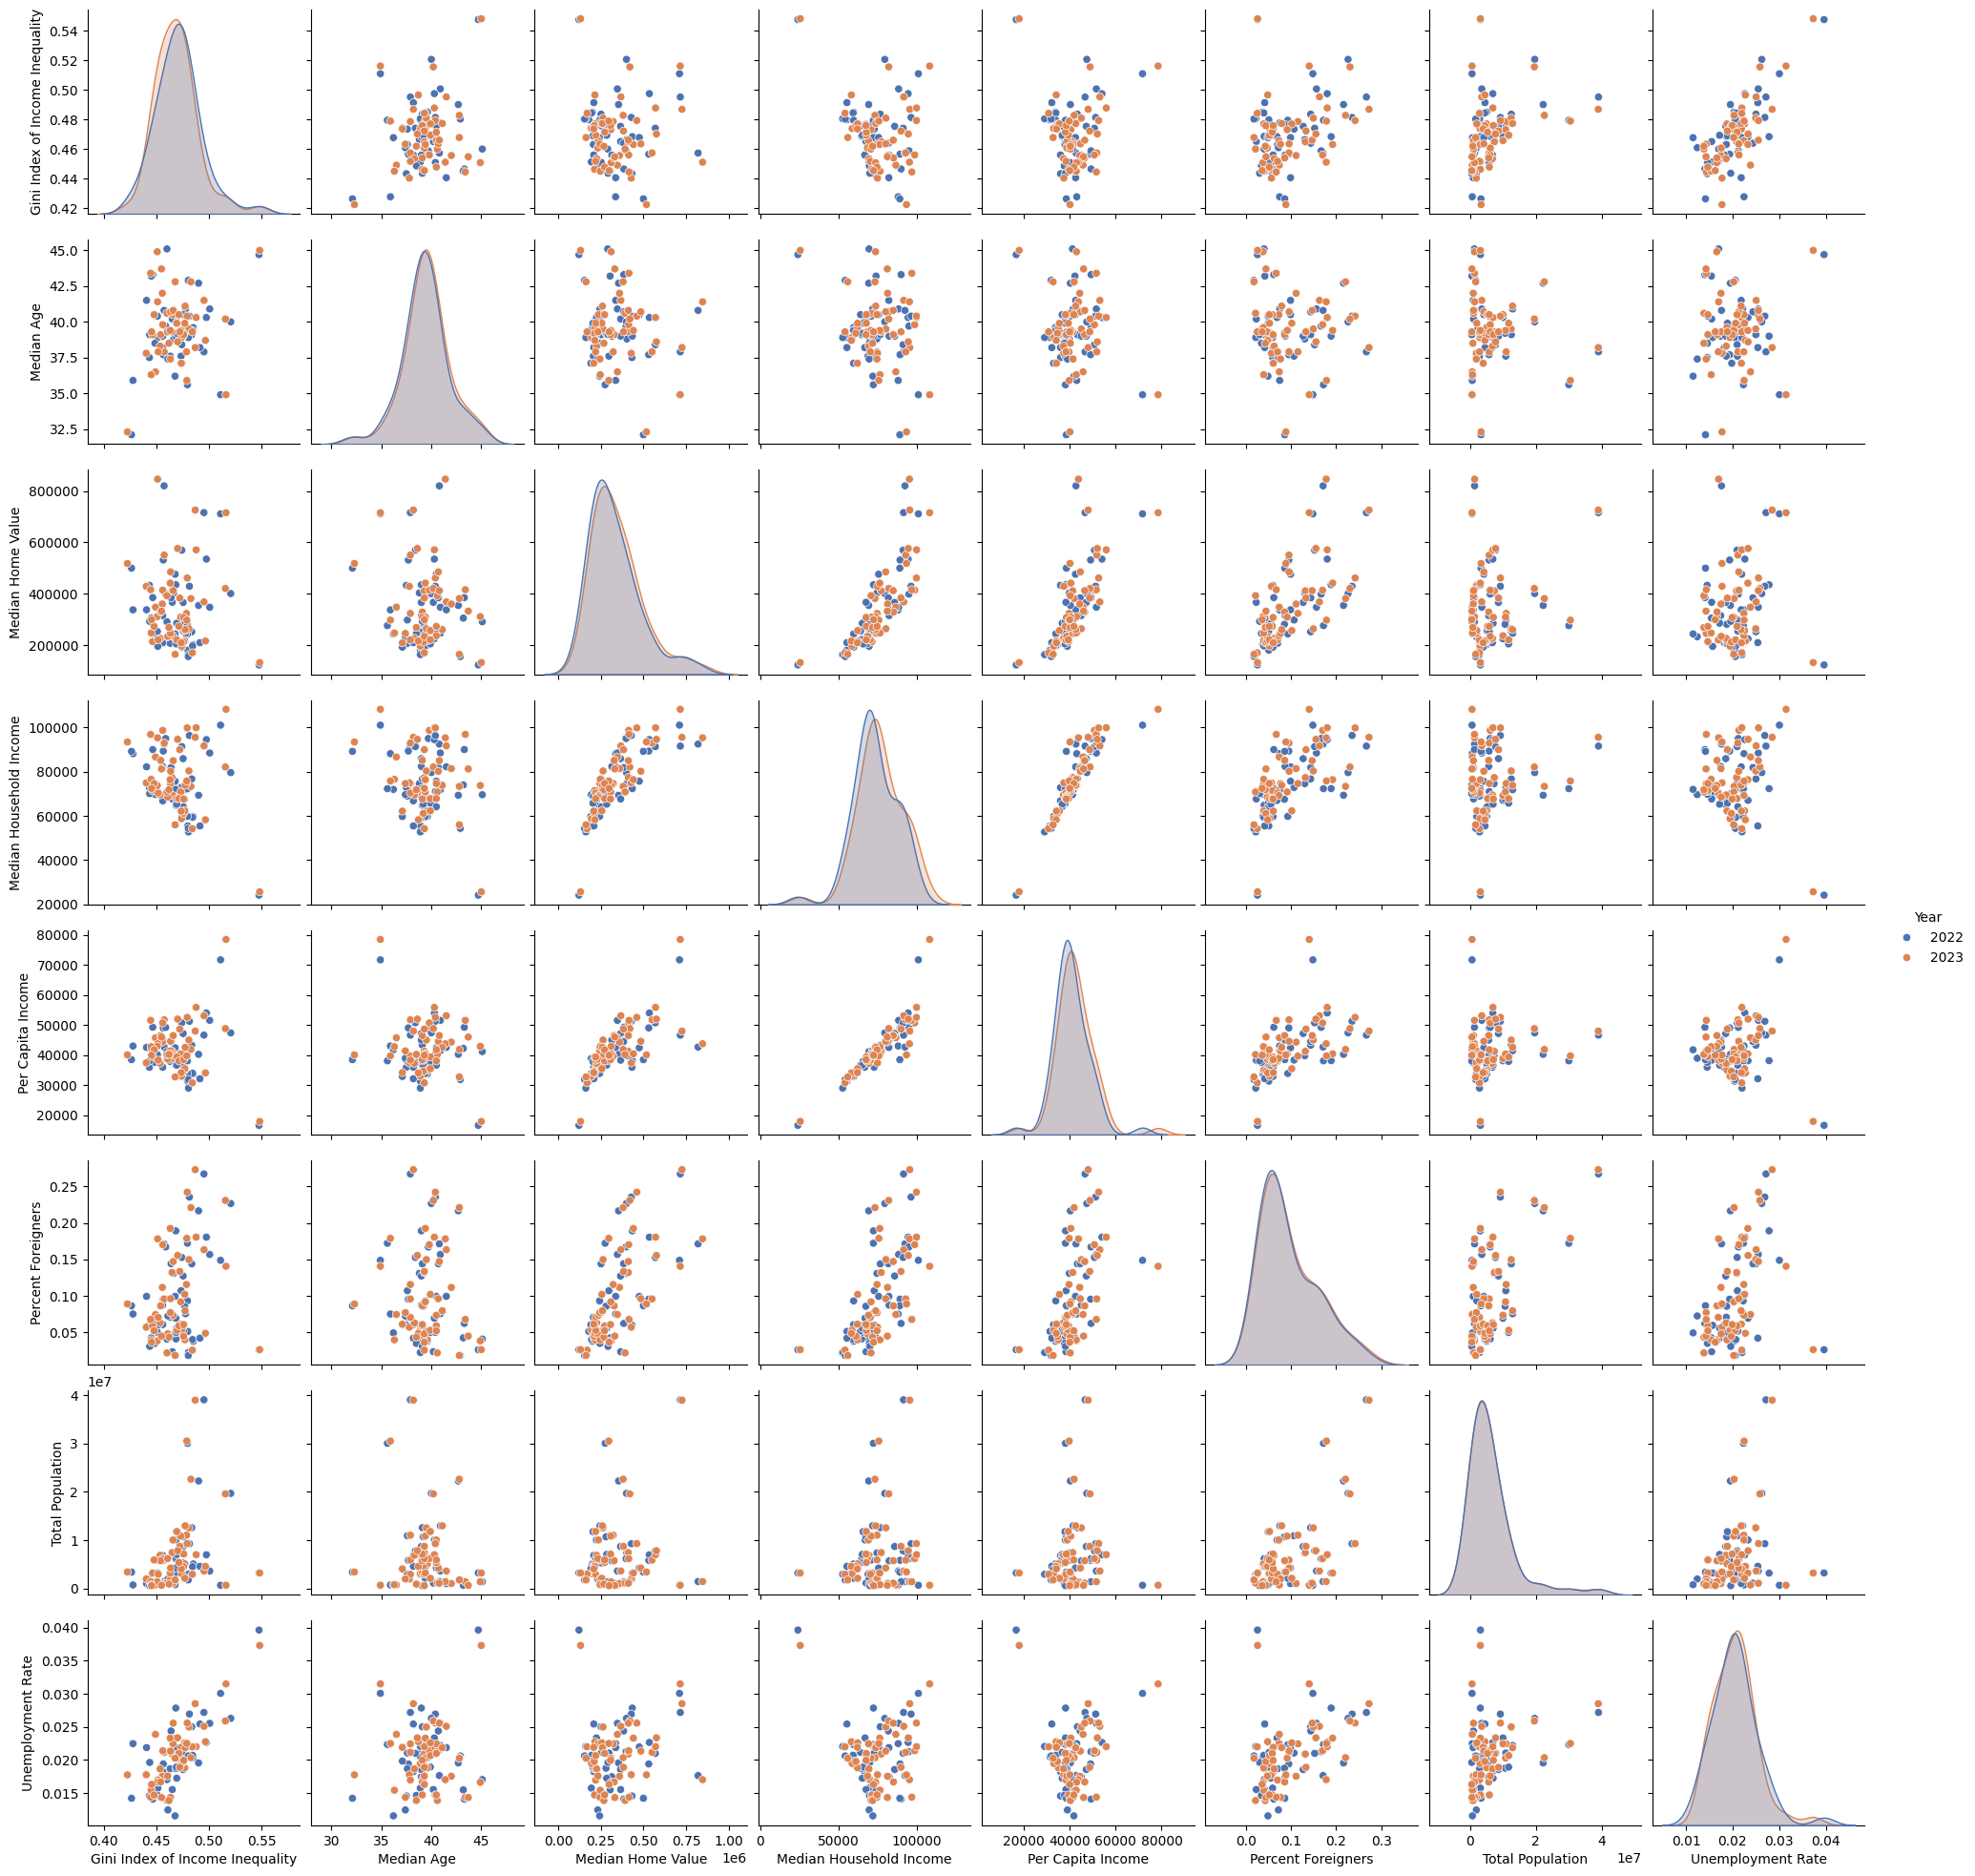

In [11]:
# Let's plot a SPLOM to see any dependencies/ correlations among the features

# acs_df.columns
# acs_df.info() # Check dtypes
numeric_and_year_cols = [col for col in acs_df.columns if 'State' not in col]

# SPLOM by year
img_name = 'acs_SPLOMs'
tmp = acs_df[numeric_and_year_cols ].copy()
sns.pairplot(tmp, hue="Year", palette='deep')
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

# # Load saved SPLOM
# img = mpimg.imread(f'visualizations/{img_name}.png')
# plt.imshow(img)
# plt.axis('off')
# plt.show()

**Findings**
- Dominance of Linear correlations.
- Expect dimensionality reduction with PCA perform well.
- No clear differences between 2022 and 2023 data. --> Perform PCA based on 2023 data

In [12]:
acs_2023_df['Year'].unique()

array([2023])

## Dimensionality Reduction

### PCA

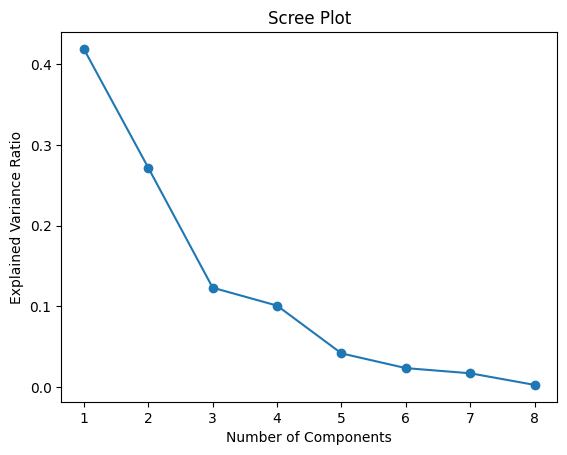

In [13]:
# Normalize for PCA
scaler = StandardScaler()
acs_2023_df_scaled = acs_2023_df.copy()
# Select numeric cols
numeric_cols = [col for col in numeric_and_year_cols if col != "Year"]
acs_2023_df_scaled[numeric_cols] = scaler.fit_transform(acs_2023_df_scaled[numeric_cols])

# Perform PCA 
pca = PCA() # Default n_components = number of existing features
pca.fit(acs_2023_df_scaled[numeric_cols])


# Select n_components
explainedVariance = pca.explained_variance_ratio_

# # Option 1 (not chosen): Based on Explained Variance -> 6
explainedVariance_cum = np.cumsum(pca.explained_variance_ratio_)
explainedVariance_cum
# n_components = np.argmax(explainedVariance_cum >= 0.95) + 1 #np.argmax returns the index of the first occurence of max value ('1') - i.e. index of first element which satisfy the criteria >0.95
# n_components #np.int64(6)

# Option 2 (chosen): Based on Visual inspection of Scree plot using Elbow method -> 3
img_name = 'PCA_ExplainedVariance_ScreePlot'
plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show() # 3 components looks good

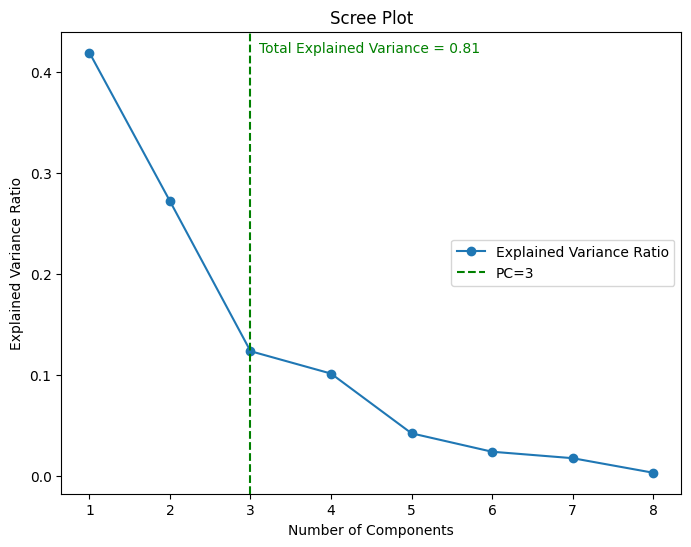

In [14]:
# Final Scree Plot

# Option 2 (chosen): Based on visual inspection -> 3 components
n_components = 3
explained_variance_at_3 = explainedVariance_cum[n_components - 1]  # Cumulative explained variance at PC = 3

# Plot Scree Plot with vertical line at PC = 3
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, marker='o', label='Explained Variance Ratio')

# Add vertical line at PC = 3
plt.axvline(x=n_components, color='g', linestyle='--', label=f'PC={n_components}')

# Annotate with explained variance at PC = 3
plt.text(n_components + 0.1, explainedVariance[0], f'Total Explained Variance = {explained_variance_at_3:.2f}', color='green')

# Labels and title
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

# Save and show plot
img_name = 'PCA_ExplainedVariance_ScreePlot'
plt.legend()
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

In [15]:
# let's do PCA with 3 components
n=3
pca = PCA(n_components=n)
# pca.fit(acs_2023_df_scaled[num_cols])
pca_2023_result = pca.fit_transform(acs_2023_df_scaled[numeric_cols])

# PCA results 
pca_2023_df = pd.DataFrame(pca_2023_result, columns=[f'PC{i+1}' for i in range(n)])
# Concatenate the original data with PCA components
acs_with_pca_2023_df = pd.concat([acs_2023_df.reset_index(drop=True), pca_2023_df], axis=1)
acs_with_pca_2023_df.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,PC1,PC2,PC3
0,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766,-1.817882,0.407587,-0.245614
1,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408,0.375078,-1.054928,-0.636094
2,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999,0.464010,-0.009276,-0.163031
3,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919,-2.022604,0.424492,-0.493996
4,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065,5.039345,2.426022,-1.864246


In [16]:
# Explained Variance
explainedVariance_byComponent = pca.explained_variance_ratio_
# explainedVariance_byComponent
explainedVariance_total = np.cumsum(pca.explained_variance_ratio_)[-1]
# explainedVariance_total

# Component contributions (loadings)
component_cont = pca.components_
# component_cont
pca_components_df = pd.DataFrame(pca.components_, columns=numeric_cols, index=[f'PC{i+1}' for i in range(n)])
pca_components_df.head()

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,Total Population,Unemployment Rate
PC1,0.085369,-0.129019,0.469444,0.473149,0.453934,0.473651,0.247584,0.200299
PC2,0.610310,0.196021,-0.138316,-0.309755,-0.195426,0.175410,0.326866,0.546093
PC3,0.145436,0.812192,0.152164,0.105712,0.235513,-0.051194,-0.475288,0.029638


**Main PC Components** 
- PC1: Home Value, Income (Household & Per Capita), Percent Foreigners
- PC2: Gini Index, Unemployment Rate
- PC3: Age, Total Population

PC1 explains 41.87% of the total variance


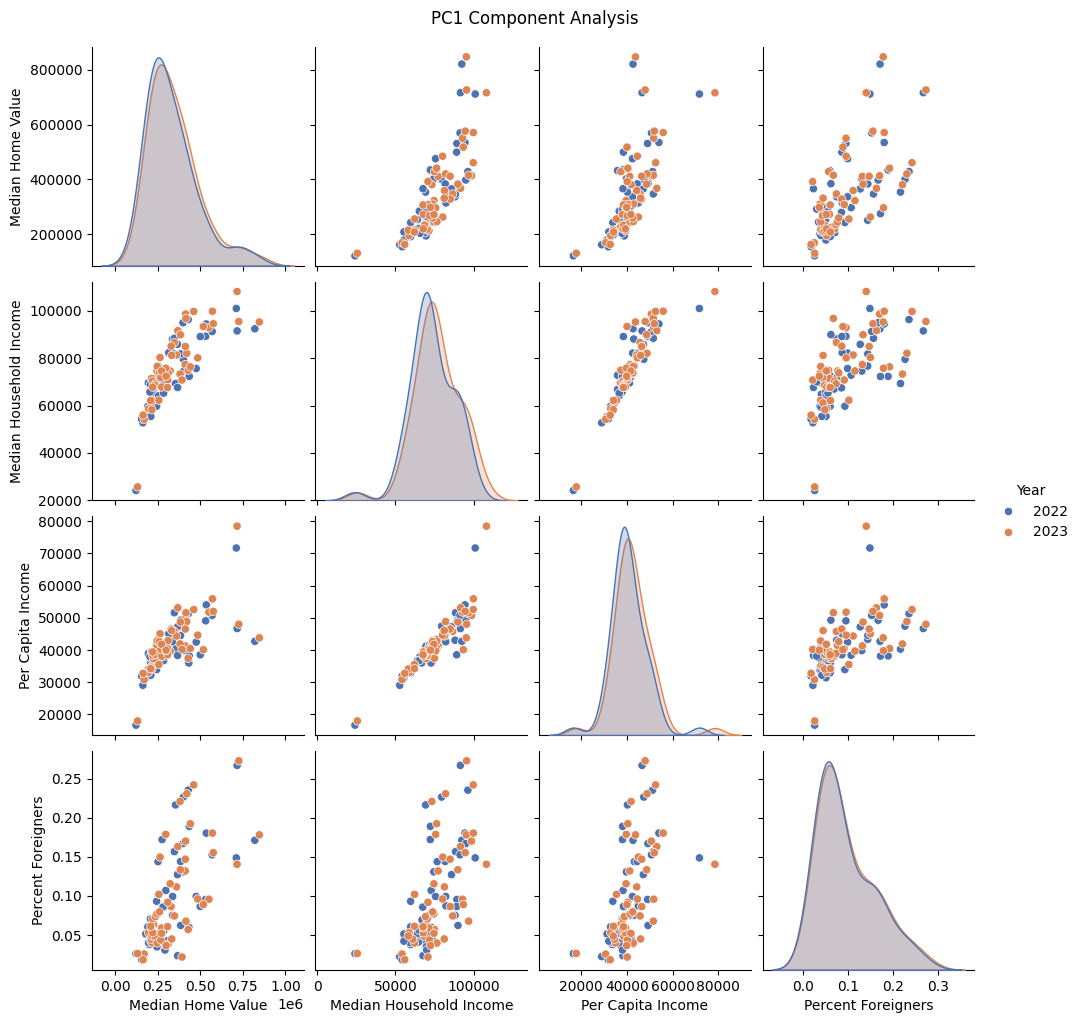

In [17]:
# Analyse PC1 on the original df with both 2022 and 2023 data
explainedVariance_PC1 = explainedVariance_byComponent[0]
print(f"PC1 explains {explainedVariance_PC1*100:.2f}% of the total variance")

main_cols_pc1 = ['Median Home Value','Median Household Income', 'Per Capita Income', 'Percent Foreigners']
img_name_pc1 = 'acs_PC1_SPLOMs'
cols = main_cols_pc1
img_name = img_name_pc1

tmp = acs_df[cols+['Year']].copy()
pairplot = sns.pairplot(tmp, hue="Year", palette='deep')
pairplot.figure.suptitle('PC1 Component Analysis', y=1.02) 
# plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

**Observations for PC1**
- Main components of PC1 are linearly correlated.  - expected because PC1 captures the maximum variance in the data, which means it represents the shared variance among features. When features are correlated, their shared variance is high, and this is precisely what PCA seeks to capture in the first few principal components.

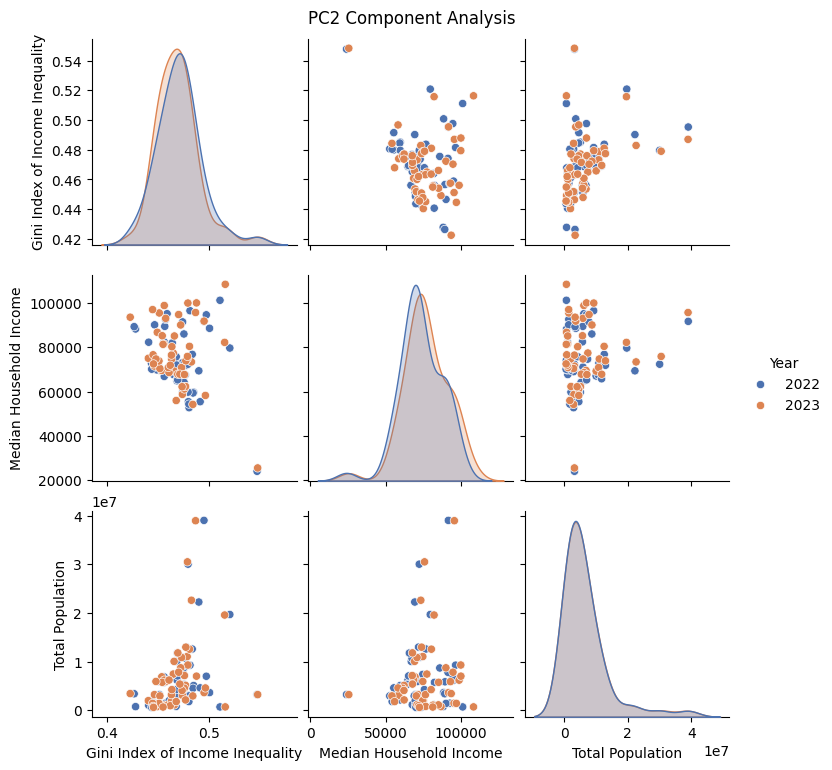

In [18]:
# Analyse PC2
# Main features for PC2 -> No strong correlations observed; Expected because it's capturing the remnants from PC1 (side trends)
main_cols_pc2 = ['Gini Index of Income Inequality','Median Household Income', 'Total Population']
img_name_pc2 = 'acs_PC2_SPLOMs'
cols = main_cols_pc2
img_name = img_name_pc2

tmp = acs_df[cols+['Year']].copy()
pairplot = sns.pairplot(tmp, hue="Year", palette='deep')
pairplot.figure.suptitle('PC2 Component Analysis', y=1.02) 
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

**Observations for PC2**
- The variables seem to be less correlated compared to PC1, showing no clear linear relationship.
- PC2 could be capturing the variance that is not explained by their correlation (e.g., differences in state-level demographics, economic policies)/ For instance, PC1 might capture shared relationships between highly correlated variables like Median Household Income and Total Population, while PC2 could capture variance in variables that don’t follow the same strong correlations, like the Gini Index of Income Inequality or Median Age.
- Variations in income inequality that isn't strongly related to household income or home values but still carry important information.

In [19]:
acs_with_pca_2023_df.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,PC1,PC2,PC3
0,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766,-1.817882,0.407587,-0.245614
1,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408,0.375078,-1.054928,-0.636094
2,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999,0.464010,-0.009276,-0.163031
3,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919,-2.022604,0.424492,-0.493996
4,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065,5.039345,2.426022,-1.864246


### MDS

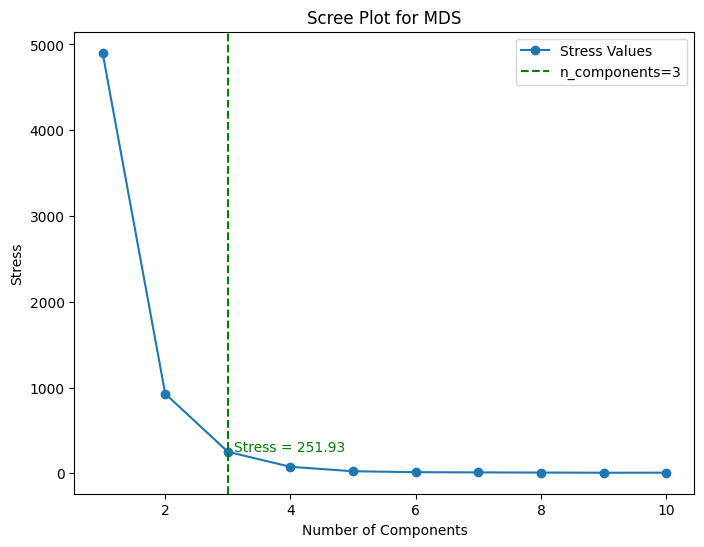

In [41]:
X = acs_with_pca_2023_df  

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run MDS for different numbers of components
stress_values = []
n_components_range = np.arange(1, 11)  # Try MDS with 1 to 10 dimensions

for n_components in n_components_range:
    mds = MDS(n_components=n_components, random_state=42)
    mds.fit(X_scaled)
    stress_values.append(mds.stress_)

# Find optimal number of components (elbow point)
optimal_n_components = 3  # Based on visual inspection

# Plot scree-like plot for MDS stress
plt.figure(figsize=(8, 6))
plt.plot(n_components_range, stress_values, marker='o', label='Stress Values')

# Add vertical line at the chosen n_components
plt.axvline(x=optimal_n_components, color='g', linestyle='--', label=f'n_components={optimal_n_components}')

# Annotate with stress at the chosen n_components
plt.text(optimal_n_components + 0.1, stress_values[optimal_n_components - 1], 
         f'Stress = {stress_values[optimal_n_components - 1]:.2f}', color='green')

# Labels and title
plt.xlabel('Number of Components')
plt.ylabel('Stress')
plt.title('Scree Plot for MDS')

# Save and show plot
img_name = 'MDS_Stress_ScreePlot'
plt.legend()
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()


In [45]:
# Perform MDS with n_components = 3
n=3
mds = MDS(n_components=n, random_state=42)

# MDS results 
mds_2023_result = mds.fit_transform(acs_2023_df_scaled[numeric_cols])
mds_2023_df = pd.DataFrame(mds_2023_result, columns=[f'MDS_D{i+1}' for i in range(n)])
# Concatenate the original data with mds components
acs_with_mds_2023_df = pd.concat([acs_2023_df.reset_index(drop=True), mds_2023_df], axis=1)
acs_with_mds_2023_df.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,MDS_D1,MDS_D2,MDS_D3
0,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766,0.952345,0.212468,-1.707963
1,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408,-1.878192,-0.771679,-0.416824
2,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999,-0.238285,-0.201785,0.376492
3,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919,0.843026,-0.101269,-2.049780
4,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065,0.999952,-3.416455,5.279470


## Clustering

### KMeans

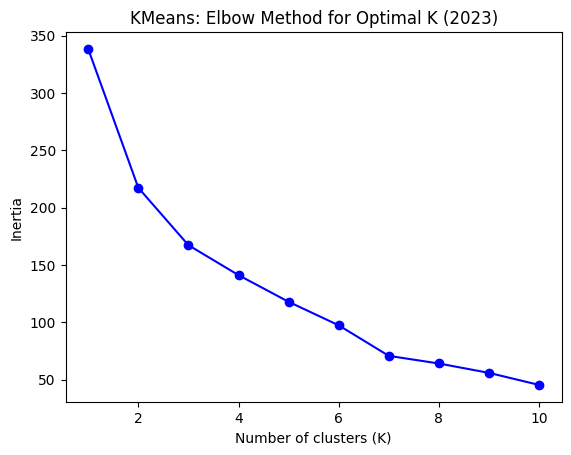

In [20]:
# Perform KMeans Clustering on PCA results (PCA + KMeans)
pca_cols = [col for col in acs_with_pca_2023_df if 'PC' in col]

# Find most appropriate number of clusters
# Define range of K values
K = range(1, 11)

# Store inertia values for each K
# Inertia = within-cluster sum of squares (WCSS) 
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(acs_with_pca_2023_df[pca_cols])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
img_name = 'KMeans_with_PCA_Elbow'
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('KMeans: Elbow Method for Optimal K (2023)')
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()
# K=3,4 both look ok. Let's compare Silhoutte Scores

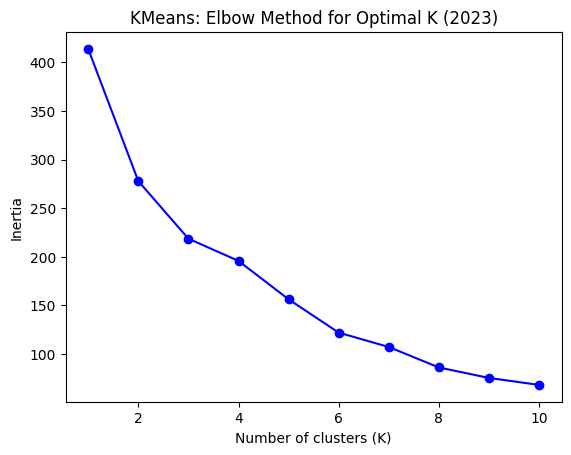

In [46]:
# Perform KMeans Clustering on MDS results (MDS + KMeans)
mds_cols = [col for col in acs_with_mds_2023_df if 'MDS' in col]

# Find most appropriate number of clusters
# Define range of K values
K = range(1, 11)

# Store inertia values for each K
# Inertia = within-cluster sum of squares (WCSS) 
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(acs_with_mds_2023_df[mds_cols])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
img_name = 'KMeans_with_MDS_Elbow'
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('KMeans: Elbow Method for Optimal K (2023)')
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()
# K=3.

In [31]:
# Compare Silhouette Score for K=3 and K=4

# For K=3
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_3.fit(acs_with_pca_2023_df[pca_cols])
labels_3 = kmeans_3.labels_

# Compute silhouette score for K=3
silhouette_score_k3 = silhouette_score(acs_with_pca_2023_df[pca_cols], labels_3)
print(f'Silhouette Score for K=3: {silhouette_score_k3}')

# For K=4
kmeans_4 = KMeans(n_clusters=4, random_state=42)
kmeans_4.fit(acs_with_pca_2023_df[pca_cols])
labels_4 = kmeans_4.labels_

# Compute silhouette score for K=4
silhouette_score_k4 = silhouette_score(acs_with_pca_2023_df[pca_cols], labels_4)
print(f'Silhouette Score for K=4: {silhouette_score_k4}')

Silhouette Score for K=3: 0.29835630706652627
Silhouette Score for K=4: 0.2586042606267848


In [34]:
kmeans.cluster_centers_  # Centroid coordinates

array([[-0.64055006, -1.20745058,  0.01895128],
       [-1.43201912,  1.02271128, -0.15308998],
       [ 2.23270669,  0.48660194,  0.12940088]])

In [36]:
labels_3_ = kmeans_3.fit_predict(acs_with_pca_2023_df[pca_cols])
# assert labels_3 == labels_3_
np.array_equal(labels_3, labels_3_)

True

**Silhouette Score Comparison**
- Silhouette Score for K=3: 0.29835630706652627
- Silhouette Score for K=4: 0.2586042606267848
- K=3 gives better clustering

In [48]:
k = 3

kmeans = KMeans(n_clusters=k, random_state=42)
acs_with_pca_and_kmeans_2023 = acs_with_pca_2023_df.copy()
acs_with_pca_and_kmeans_2023['KMeans_Cluster'] = kmeans.fit_predict(acs_with_pca_and_kmeans_2023[pca_cols])
acs_with_pca_and_kmeans_2023.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,PC1,PC2,PC3,KMeans_Cluster
0,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766,-1.817882,0.407587,-0.245614,1
1,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408,0.375078,-1.054928,-0.636094,0
2,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999,0.464010,-0.009276,-0.163031,0
3,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919,-2.022604,0.424492,-0.493996,1
4,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065,5.039345,2.426022,-1.864246,2


In [49]:
k = 3

kmeans = KMeans(n_clusters=k, random_state=42)
acs_with_mds_and_kmeans_2023 = acs_with_mds_2023_df.copy()
acs_with_mds_and_kmeans_2023['KMeans_Cluster'] = kmeans.fit_predict(acs_with_mds_and_kmeans_2023[mds_cols])
acs_with_mds_and_kmeans_2023.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,MDS_D1,MDS_D2,MDS_D3,KMeans_Cluster
0,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766,0.952345,0.212468,-1.707963,2
1,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408,-1.878192,-0.771679,-0.416824,0
2,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999,-0.238285,-0.201785,0.376492,0
3,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919,0.843026,-0.101269,-2.049780,2
4,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065,0.999952,-3.416455,5.279470,1


In [52]:
# Insert State Names
acs_with_pca_and_kmeans_2023 = pd.merge(acs_with_pca_and_kmeans_2023, state_df, on = 'State Code (FIPS)', how = 'left')#.dropna() 
acs_with_pca_and_kmeans_2023.to_csv('assets/acs_with_pca_and_kmeans_2023.csv', index=None)
acs_with_pca_and_kmeans_2023.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,PC1,PC2,PC3,KMeans_Cluster,State Name,State Code (USPS)
0,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766,-1.817882,0.407587,-0.245614,1,Alabama,AL
1,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408,0.375078,-1.054928,-0.636094,0,Alaska,AK
2,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999,0.464010,-0.009276,-0.163031,0,Arizona,AZ
3,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919,-2.022604,0.424492,-0.493996,1,Arkansas,AR
4,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065,5.039345,2.426022,-1.864246,2,California,CA


In [50]:
# Insert State Names
acs_with_mds_and_kmeans_2023 = pd.merge(acs_with_mds_and_kmeans_2023, state_df, on = 'State Code (FIPS)', how = 'left')#.dropna() 
acs_with_mds_and_kmeans_2023.to_csv('assets/acs_with_mds_and_kmeans_2023.csv', index=None)
acs_with_mds_and_kmeans_2023.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,MDS_D1,MDS_D2,MDS_D3,KMeans_Cluster,State Name,State Code (USPS)
0,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766,0.952345,0.212468,-1.707963,2,Alabama,AL
1,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408,-1.878192,-0.771679,-0.416824,0,Alaska,AK
2,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999,-0.238285,-0.201785,0.376492,0,Arizona,AZ
3,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919,0.843026,-0.101269,-2.049780,2,Arkansas,AR
4,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065,0.999952,-3.416455,5.279470,1,California,CA


In [53]:
# Group by 'Cluster' and extract the 'State Name' as a list for each cluster
kmeans_clusters_dict = acs_with_pca_and_kmeans_2023.groupby('KMeans_Cluster')['State Name'].apply(list).to_dict()
# clusters_dict
kmeans_clusters_df = pd.DataFrame.from_dict(kmeans_clusters_dict, orient='index').transpose() # Dict keys as index
kmeans_clusters_df.columns = ['Cluster 0', 'Cluster 1', 'Cluster 2']
kmeans_clusters_df.to_csv('assets/PCA_KMeans_clusters.csv')
kmeans_clusters_df

,Cluster 0,Cluster 1,Cluster 2
0,Alaska,Alabama,California
1,Arizona,Arkansas,Colorado
2,Delaware,Georgia,Connecticut
3,Idaho,Kentucky,District of Columbia
4,Indiana,Louisiana,Florida
5,Iowa,Michigan,Hawaii
6,Kansas,Mississippi,Illinois
7,Maine,New Mexico,Maryland
8,Minnesota,North Carolina,Massachusetts
9,Missouri,Ohio,Nevada


In [54]:
# Group by 'Cluster' and extract the 'State Name' as a list for each cluster
kmeans_clusters_dict = acs_with_mds_and_kmeans_2023.groupby('KMeans_Cluster')['State Name'].apply(list).to_dict()
# clusters_dict
kmeans_clusters_df = pd.DataFrame.from_dict(kmeans_clusters_dict, orient='index').transpose() # Dict keys as index
kmeans_clusters_df.columns = ['Cluster 0', 'Cluster 1', 'Cluster 2']
# kmeans_clusters_df.to_csv('assets/MDS_KMeans_clusters.csv')
kmeans_clusters_df

,Cluster 0,Cluster 1,Cluster 2
0,Alaska,California,Alabama
1,Arizona,Colorado,Arkansas
2,Delaware,Connecticut,Georgia
3,Idaho,District of Columbia,Kentucky
4,Indiana,Florida,Louisiana
5,Iowa,Hawaii,Michigan
6,Kansas,Illinois,Mississippi
7,Maine,Maryland,New Mexico
8,Minnesota,Massachusetts,North Carolina
9,Missouri,Nevada,Ohio


### DBSCAN

In [25]:
# # Let's try to optimize DBSCAN first
# X_pca= pca_2023_result
# # Try different values of eps and min_samples
# eps_values = [0.3, 0.5, 0.7]  # Test a range of eps values
# min_samples_values = [5, 10, 15]  # Test different min_samples values

# # Loop over the eps and min_samples values to find the best combination
# for eps in eps_values:
#     for min_samples in min_samples_values:
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = dbscan.fit_predict(X_pca)  # Assuming X_pca is your PCA-reduced data
        
#         # Plot the results
#         plt.figure(figsize=(8,6))
#         plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
#         plt.title(f'DBSCAN with eps={eps} and min_samples={min_samples}')
#         plt.xlabel('PC1')
#         plt.ylabel('PC2')
#         plt.show()
#         #All don't look too good..


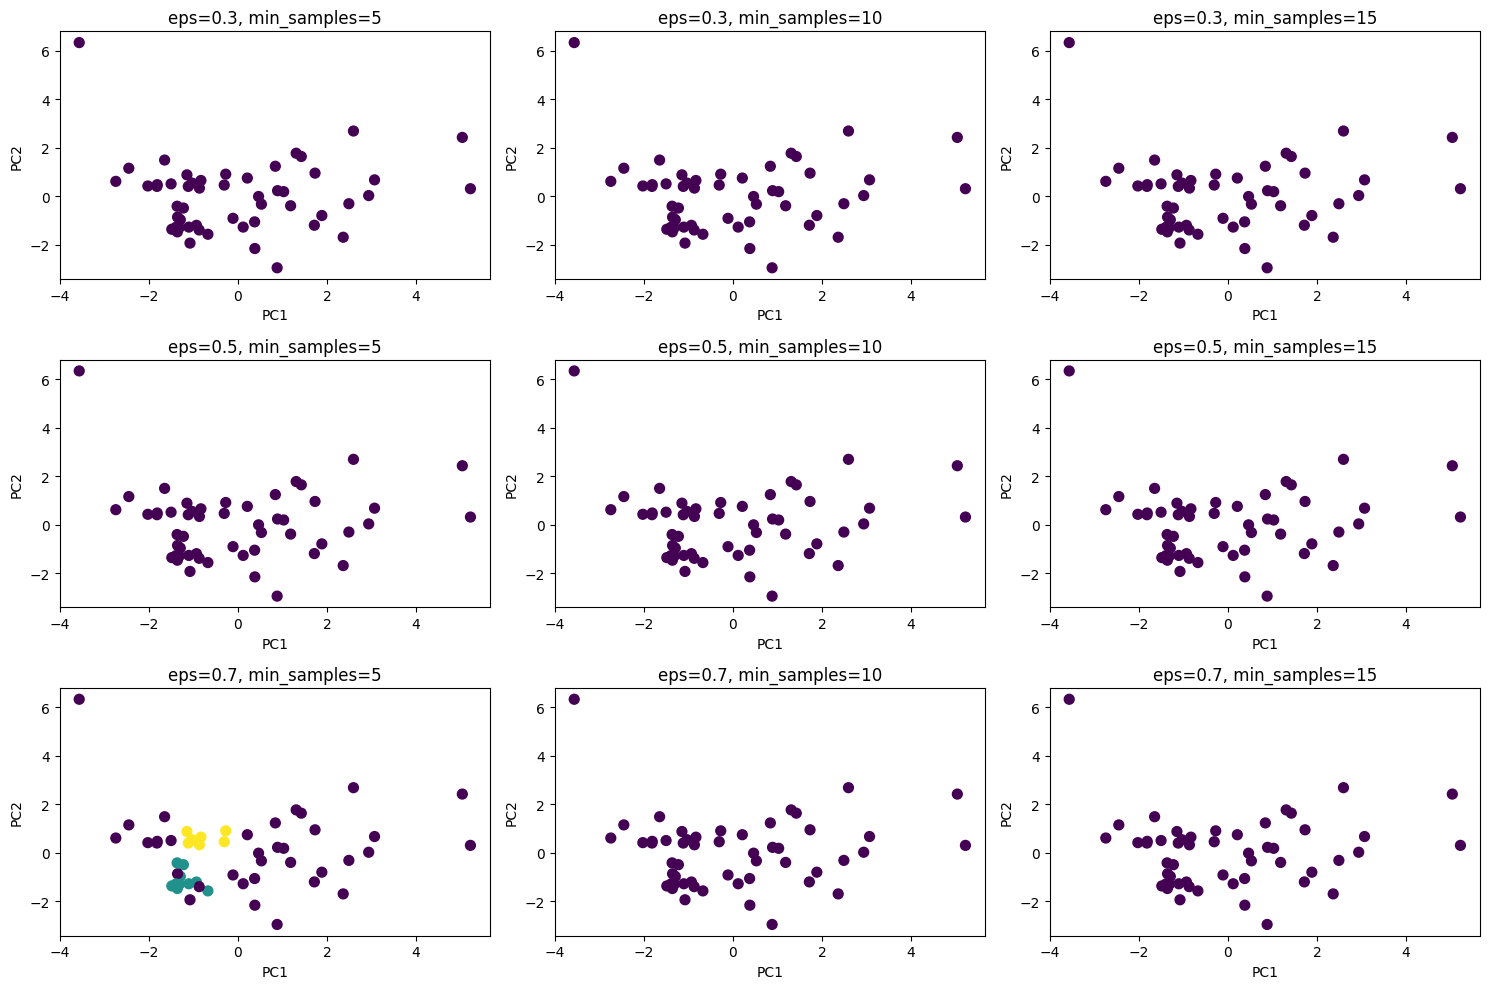

In [26]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Set up parameters
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [5, 10, 15]
X_pca = pca_2023_result  # Assuming this is your PCA-reduced data

# Create a figure with a grid of subplots
fig, axes = plt.subplots(len(eps_values), len(min_samples_values), figsize=(15, 10))

# Loop over eps and min_samples values to generate subplots
for row, eps in enumerate(eps_values):
    for col, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca)

        # Plot the results on the corresponding subplot
        ax = axes[row, col]
        ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
        ax.set_title(f'eps={eps}, min_samples={min_samples}')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')

# Adjust layout to make sure titles and labels fit
plt.tight_layout()

# Show the combined plot with all subplots
plt.show()


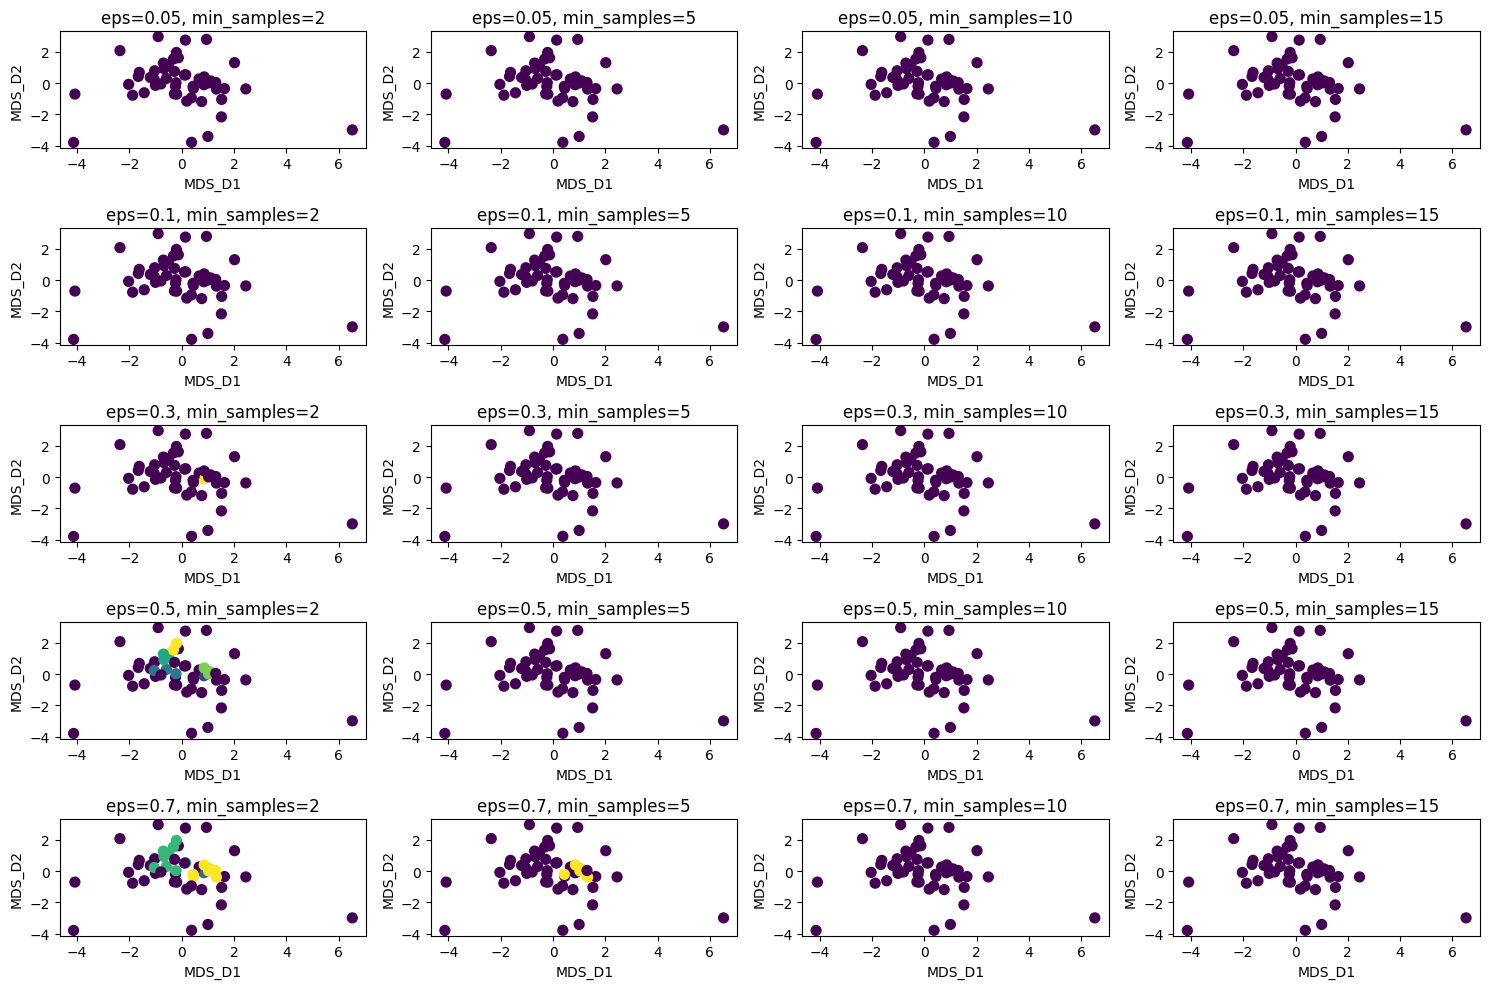

In [66]:

# Set up parameters
eps_values = [0.05,0.1, 0.3, 0.5, 0.7]
min_samples_values = [2, 5, 10, 15]
X_mds = mds_2023_result  # Assuming this is your PCA-reduced data

# Create a figure with a grid of subplots
fig, axes = plt.subplots(len(eps_values), len(min_samples_values), figsize=(15, 10))

# Loop over eps and min_samples values to generate subplots
for row, eps in enumerate(eps_values):
    for col, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_mds)

        # Plot the results on the corresponding subplot
        ax = axes[row, col]
        ax.scatter(X_mds[:, 0], X_mds[:, 1], c=labels, cmap='viridis', s=50)
        ax.set_title(f'eps={eps}, min_samples={min_samples}')
        ax.set_xlabel('MDS_D1')
        ax.set_ylabel('MDS_D2')

# Adjust layout to make sure titles and labels fit
plt.tight_layout()

# Show the combined plot with all subplots
plt.show()


In [ ]:
#try D1,D3
# Set up parameters
eps_values = [0.05,0.1, 0.3, 0.5, 0.7]
min_samples_values = [2, 5, 10, 15]
X_mds = mds_2023_result  # Assuming this is your PCA-reduced data

# Create a figure with a grid of subplots
fig, axes = plt.subplots(len(eps_values), len(min_samples_values), figsize=(15, 10))

# Loop over eps and min_samples values to generate subplots
for row, eps in enumerate(eps_values):
    for col, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_mds)

        # Plot the results on the corresponding subplot
        ax = axes[row, col]
        ax.scatter(X_mds[:, 0], X_mds[:, 1], c=labels, cmap='viridis', s=50)
        ax.set_title(f'eps={eps}, min_samples={min_samples}')
        ax.set_xlabel('MDS_D1')
        ax.set_ylabel('MDS_D2')

# Adjust layout to make sure titles and labels fit
plt.tight_layout()

# Show the combined plot with all subplots
plt.show()


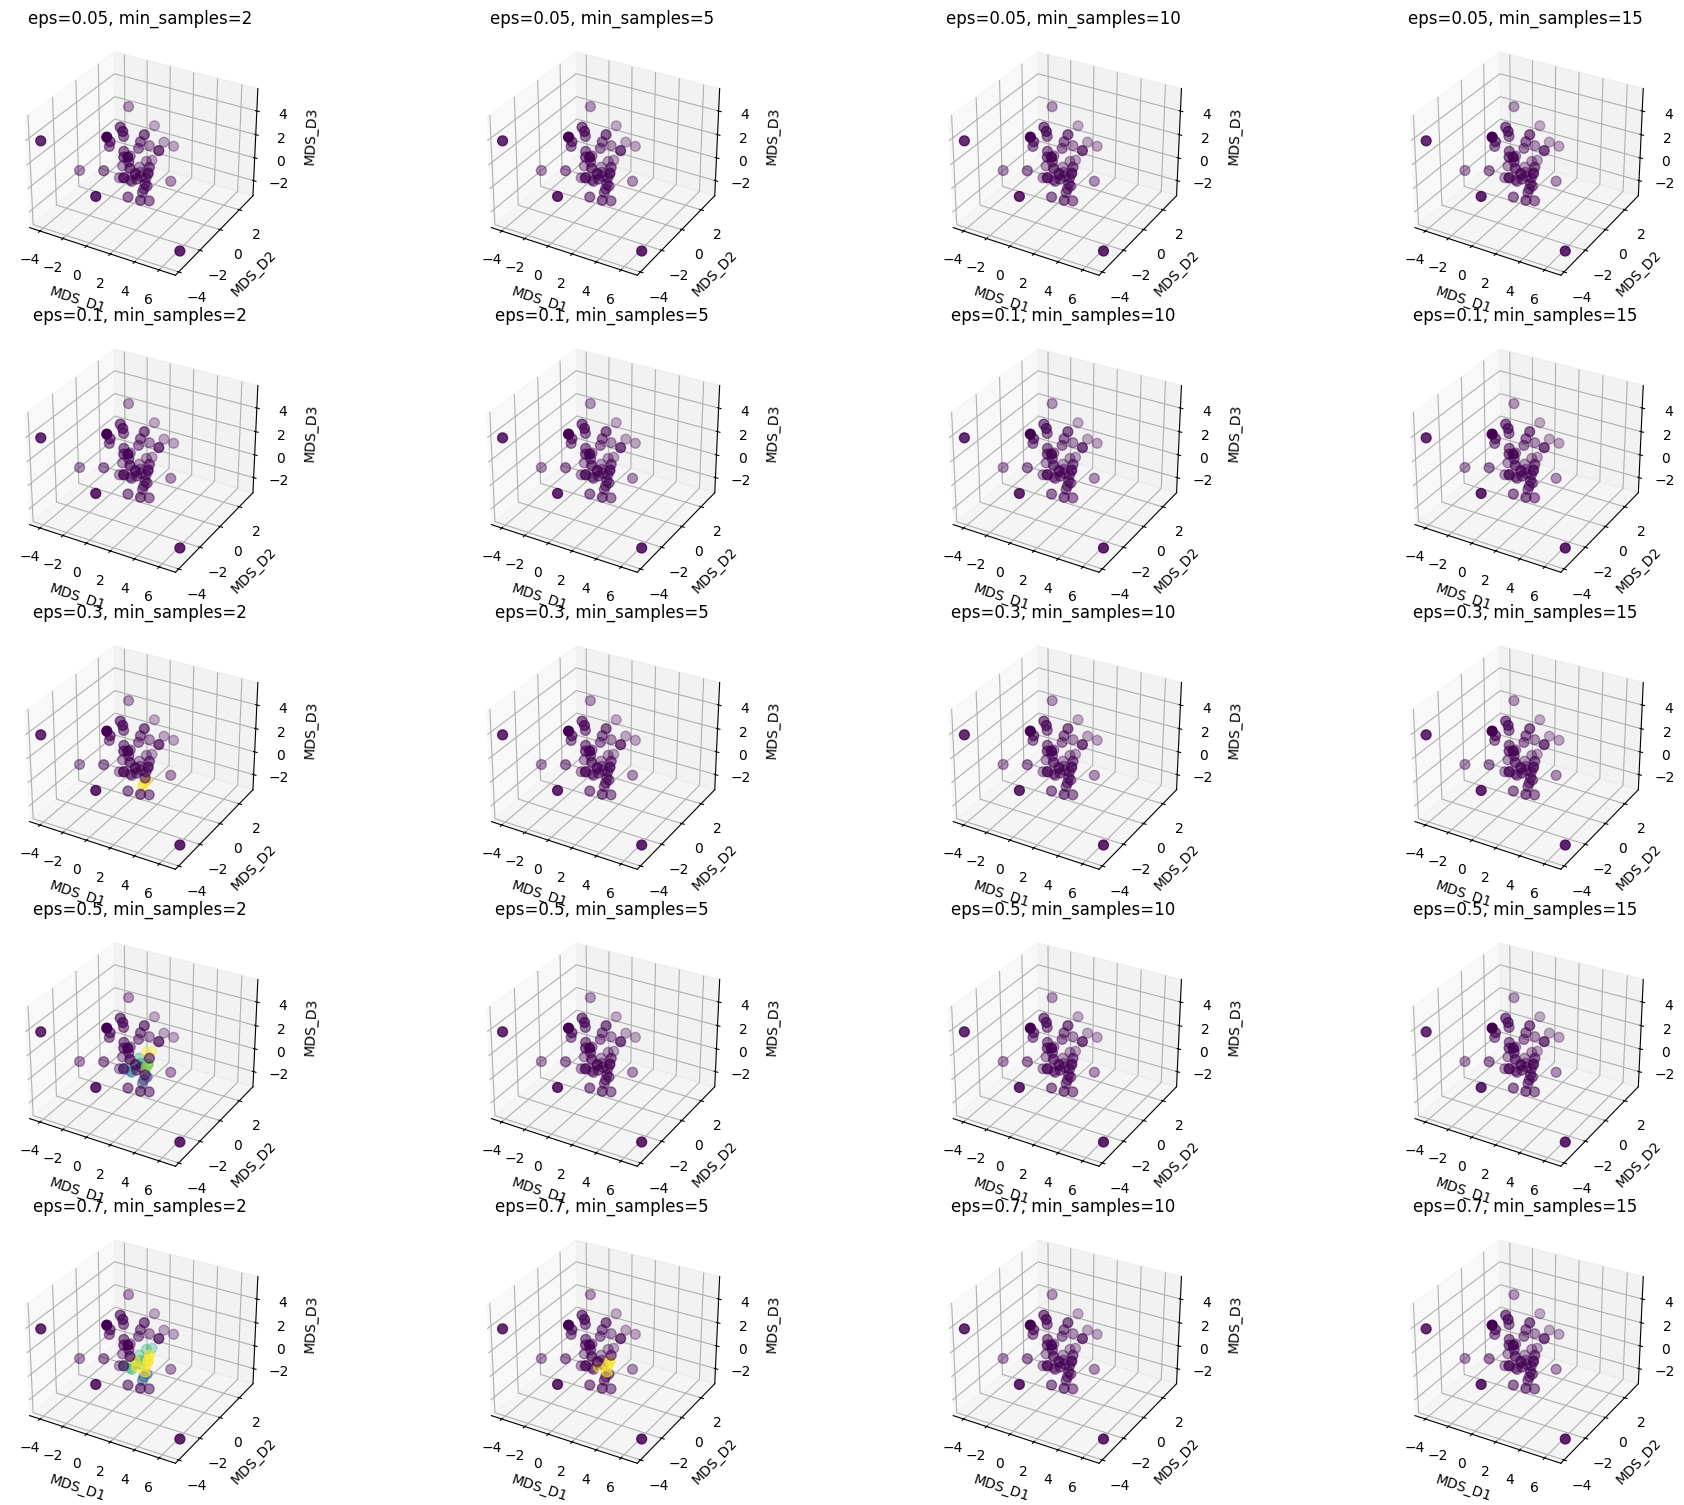

In [65]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Set up parameters
eps_values = [0.05, 0.1, 0.3, 0.5, 0.7]
min_samples_values = [2, 5, 10, 15]
X_mds = mds_2023_result  # Assuming this is your MDS-reduced data with 3 dimensions

# Create a figure with a grid of subplots
fig = plt.figure(figsize=(20, 15))

# Loop over eps and min_samples values to generate subplots
plot_idx = 1
for row, eps in enumerate(eps_values):
    for col, min_samples in enumerate(min_samples_values):
        ax = fig.add_subplot(len(eps_values), len(min_samples_values), plot_idx, projection='3d')
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_mds)

        # Plot the results in 3D
        scatter = ax.scatter(X_mds[:, 0], X_mds[:, 1], X_mds[:, 2], c=labels, cmap='viridis', s=50)
        ax.set_title(f'eps={eps}, min_samples={min_samples}')
        ax.set_xlabel('MDS_D1')
        ax.set_ylabel('MDS_D2')
        ax.set_zlabel('MDS_D3')

        plot_idx += 1

# Adjust layout to make sure titles and labels fit
plt.tight_layout()

# Show the combined plot with all subplots
plt.show()


In [27]:
# # Is DBSCAN better than KMeans? --> No

# X_pca = pca_2023_result

# # KMeans clustering
# kmeans = KMeans(n_clusters=3, random_state=42)
# kmeans_labels = kmeans.fit_predict(X_pca)

# # DBSCAN clustering
# # dbscan = DBSCAN(eps=0.5, min_samples=5)
# dbscan = DBSCAN(eps=0.7, min_samples=5)
# dbscan_labels = dbscan.fit_predict(X_pca)

# # Plot KMeans clusters
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50)
# plt.title('KMeans Clustering')
# plt.colorbar(label="Cluster")
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')

# # Plot DBSCAN clusters
# plt.subplot(1, 2, 2)
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', s=50)
# plt.title('DBSCAN Clustering')
# plt.colorbar(label="Cluster")
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')

# plt.show()


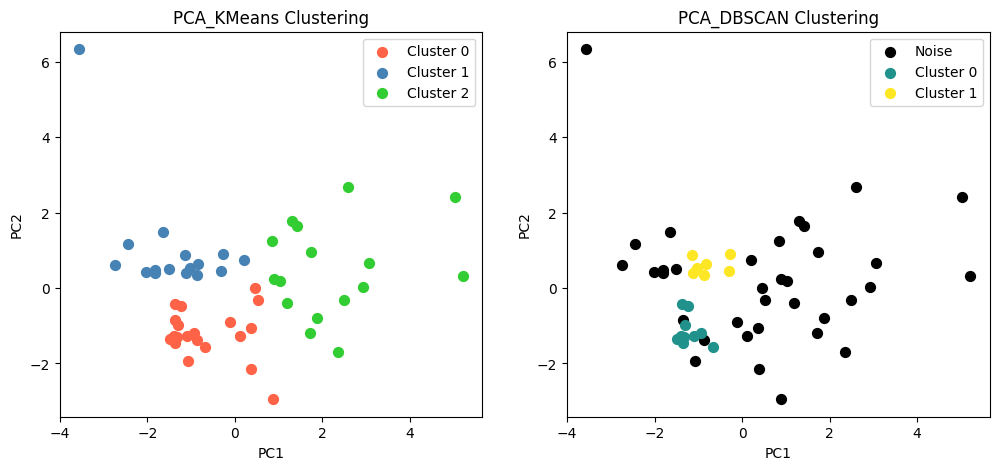

In [58]:

X_pca = pca_2023_result

# KMeans clustering
k=3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

# Custom colors for clusters (categorical colors, not continuous)
cluster_colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700']  # You can expand this list for more clusters

# Plot KMeans clusters
plt.figure(figsize=(12, 5))

# KMeans Plot
plt.subplot(1, 2, 1)
for i, color in enumerate(cluster_colors[:k]):
    plt.scatter(X_pca[kmeans_labels == i, 0], X_pca[kmeans_labels == i, 1], 
                c=color, label=f'Cluster {i}', s=50)
plt.title('PCA_KMeans Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# DBSCAN Plot
plt.subplot(1, 2, 2)

# Define color for noise points (label -1)
unique_labels = np.unique(dbscan_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Plot noise as black ('k')
        plt.scatter(X_pca[dbscan_labels == label, 0], X_pca[dbscan_labels == label, 1], 
                    c='k', s=50, label='Noise')
    else:
        # Plot clusters with categorical color map
        plt.scatter(X_pca[dbscan_labels == label, 0], X_pca[dbscan_labels == label, 1], 
                    c=[color], s=50, label=f'Cluster {label}')

plt.title('PCA_DBSCAN Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig('visualizations/PCA_KMeans_vs_PCA_DBSCAN_2023_plot.png')
plt.show()


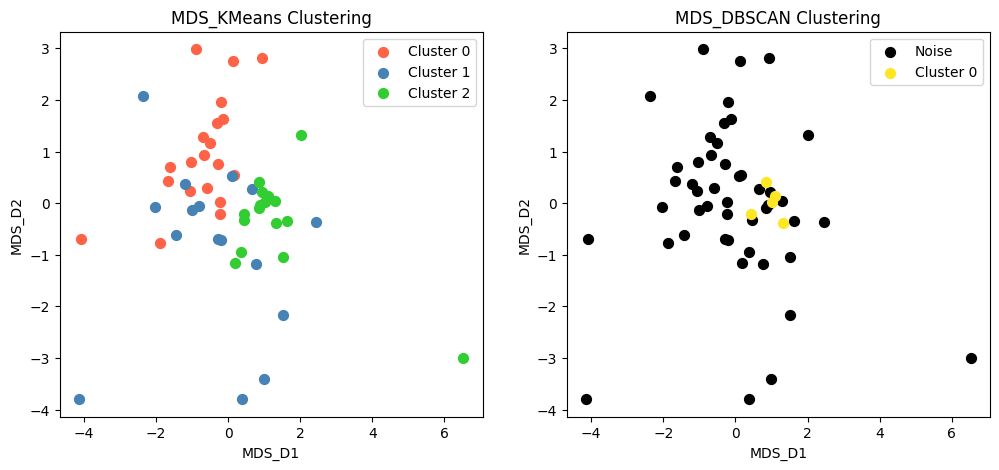

In [61]:

X_mds = mds_2023_result

# KMeans clustering
k=3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_mds)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_mds)

# Custom colors for clusters (categorical colors, not continuous)
cluster_colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700']  # You can expand this list for more clusters

# Plot KMeans clusters
plt.figure(figsize=(12, 5))

# KMeans Plot
plt.subplot(1, 2, 1)
for i, color in enumerate(cluster_colors[:k]):
    plt.scatter(X_mds[kmeans_labels == i, 0], X_mds[kmeans_labels == i, 1], 
                c=color, label=f'Cluster {i}', s=50)
plt.title('MDS_KMeans Clustering')
plt.xlabel('MDS_D1')
plt.ylabel('MDS_D2')
plt.legend()

# DBSCAN Plot
plt.subplot(1, 2, 2)

# Define color for noise points (label -1)
unique_labels = np.unique(dbscan_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Plot noise as black ('k')
        plt.scatter(X_mds[dbscan_labels == label, 0], X_mds[dbscan_labels == label, 1], 
                    c='k', s=50, label='Noise')
    else:
        # Plot clusters with categorical color map
        plt.scatter(X_mds[dbscan_labels == label, 0], X_mds[dbscan_labels == label, 1], 
                    c=[color], s=50, label=f'Cluster {label}')

plt.title('MDS_DBSCAN Clustering')
plt.xlabel('MDS_D1')
plt.ylabel('MDS_D2')
plt.legend()
plt.savefig('visualizations/MDS_KMeans_vs_MDS_DBSCAN_2023_plot.png')
plt.show()


In [29]:
# ^Next, try to PCA transform 2022 data based on fit PCA on 2023?

<Figure size 1200x800 with 0 Axes>

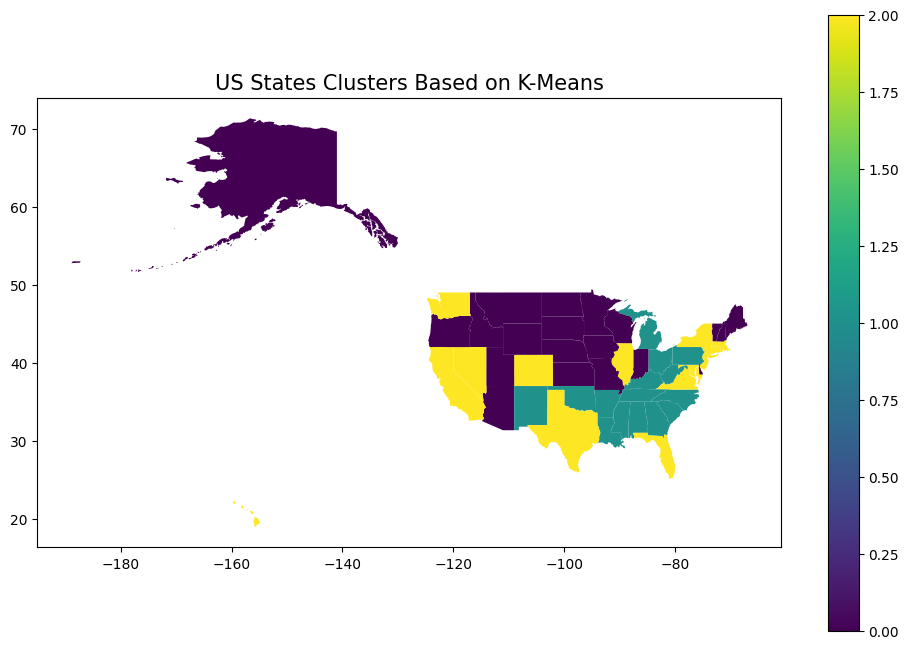

In [30]:
import geopandas as gpd

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: Load the shapefile for US states (can be done using geopandas)
# Here, we assume you have a US states shapefile available
# Use Geopandas to load a shapefile of the US
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
gdf = gpd.read_file(url)

# Step 2: Prepare your data
# Example data (replace this with your KMeans labels and state mapping)
# Assuming `acs_with_pca_2023` contains state data and corresponding KMeans cluster labels
# state_cluster_data = {
#     'Alabama': 0, 'Alaska': 1, 'Arizona': 2, 'Arkansas': 0, 'California': 2,
#     # Add other states here...
# }
acs_final = acs_with_pca_and_kmeans_2023.copy()
state_cluster_data = dict(zip(acs_final['State Name'], acs_final['Cluster']))

# # Convert the dictionary to a DataFrame and merge with the GeoDataFrame
# import pandas as pd
# state_cluster_df = pd.DataFrame(list(state_cluster_data.items()), columns=['name', 'cluster'])

# # Step 3: Merge the clustering data with the GeoDataFrame for plotting
# gdf = gdf.merge(state_cluster_df, how='left', left_on='name', right_on='name')

# # Step 4: Plot the map
# plt.figure(figsize=(12, 8))
# gdf.boundary.plot()
# gdf.plot(column='cluster', cmap='viridis', legend=True, figsize=(12, 8))

# plt.title('US States Clusters Based on K-Means', fontsize=15)
# plt.show()


# Convert the dictionary to a DataFrame and merge with the GeoDataFrame
state_cluster_df = pd.DataFrame(list(state_cluster_data.items()), columns=['name', 'cluster'])

# Step 3: Merge the clustering data with the GeoDataFrame
gdf = gdf.merge(state_cluster_df, how='left', left_on='name', right_on='name')

# Step 4: Plot the map and color the states by clusters
plt.figure(figsize=(12, 8))
gdf.plot(column='cluster', cmap='viridis', legend=True, figsize=(12, 8))

plt.title('US States Clusters Based on K-Means', fontsize=15)
plt.show()